In this project we have used this dataset found on Kaggle: [PCOS Diagnosis Dataset](https://www.kaggle.com/datasets/samikshadalvi/pcos-diagnosis-dataset). I have used it to practice classification problems in machine learning, trying to use the data to predict the occurence of PCOS diagnosis, and the features that are most important in predicting it. 

In [106]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

pcos = pd.read_csv('pcos_dataset.csv')

#Splitting out the features for future ease
features = ["Age", "BMI", "Menstrual_Irregularity", "Testosterone_Level(ng/dL)", "Antral_Follicle_Count"]
categorical_features = ["Menstrual_Irregularity"]
numerical_features = ["Age", "BMI", "Testosterone_Level(ng/dL)", "Antral_Follicle_Count"]
target_variable = "PCOS_Diagnosis"

#explorng the dataset:
print("Shape of pcos dataframe: " + str(pcos.shape) + "\n")
pcos.head()

Shape of pcos dataframe: (1000, 6)



,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [107]:
#checking potential categorical values: 
for col in ["Menstrual_Irregularity", "Antral_Follicle_Count", "PCOS_Diagnosis", "Age"]: 
    print(pcos[col].unique())

#setting some to categorical: 
pcos['Menstrual_Irregularity'] = pcos['Menstrual_Irregularity'].astype('category')
pcos['PCOS_Diagnosis'] = pcos['PCOS_Diagnosis'].astype('category')


[1 0]
[20 25 28 26  8  6 29 17  5 21 11 13 23 14 18 10 22  7 24 19 15 12 27  9
 16]
[0 1]
[24 37 32 28 25 38 43 36 40 41 21 20 39 19 29 23 45 18 42 34 44 27 33 22
 26 35 31 30]


In [108]:
#Checking for missing values:
pcos.isna().sum()

Age                          0
BMI                          0
Menstrual_Irregularity       0
Testosterone_Level(ng/dL)    0
Antral_Follicle_Count        0
PCOS_Diagnosis               0
dtype: int64

In [109]:
#checking for negative values where there shouldn't be any:
pcos.describe()

,Age,BMI,Testosterone_Level(ng/dL),Antral_Follicle_Count
count,1000.000000,1000.00000,1000.000000,1000.000000
mean,31.771000,26.38700,60.159500,17.469000
std,8.463462,4.93554,23.160204,7.069301
min,18.000000,18.10000,20.000000,5.000000
25%,24.000000,21.90000,41.700000,12.000000
50%,32.000000,26.40000,60.000000,18.000000
75%,39.000000,30.50000,80.300000,23.250000
max,45.000000,35.00000,99.800000,29.000000


## Exploring the data

We start off by plotting the countplot of the target variable `PCOS_Diagnosis`. We see tht the data is very imbalanced, as 80% of the observations do not have PCOS. We'll need to keep this in mind for later, and consider this fact when using the data in machine learning models and during the evaluation of those. 


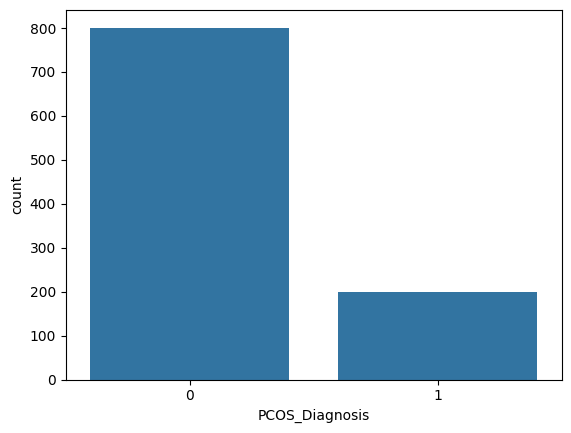

In [110]:
sns.countplot(pcos, x=target_variable)
plt.show()

Next we plot the distribution of all non-target features indicating in each graph the distribution of PCOS within this category. From these we see that possible indicators of PCOS seems to be BMI over 25, mentrual irregularity, testosterone levels above 40 and high follicle count. 
PCOS diagnosis seems to be quite evenly distributed across age groups. 

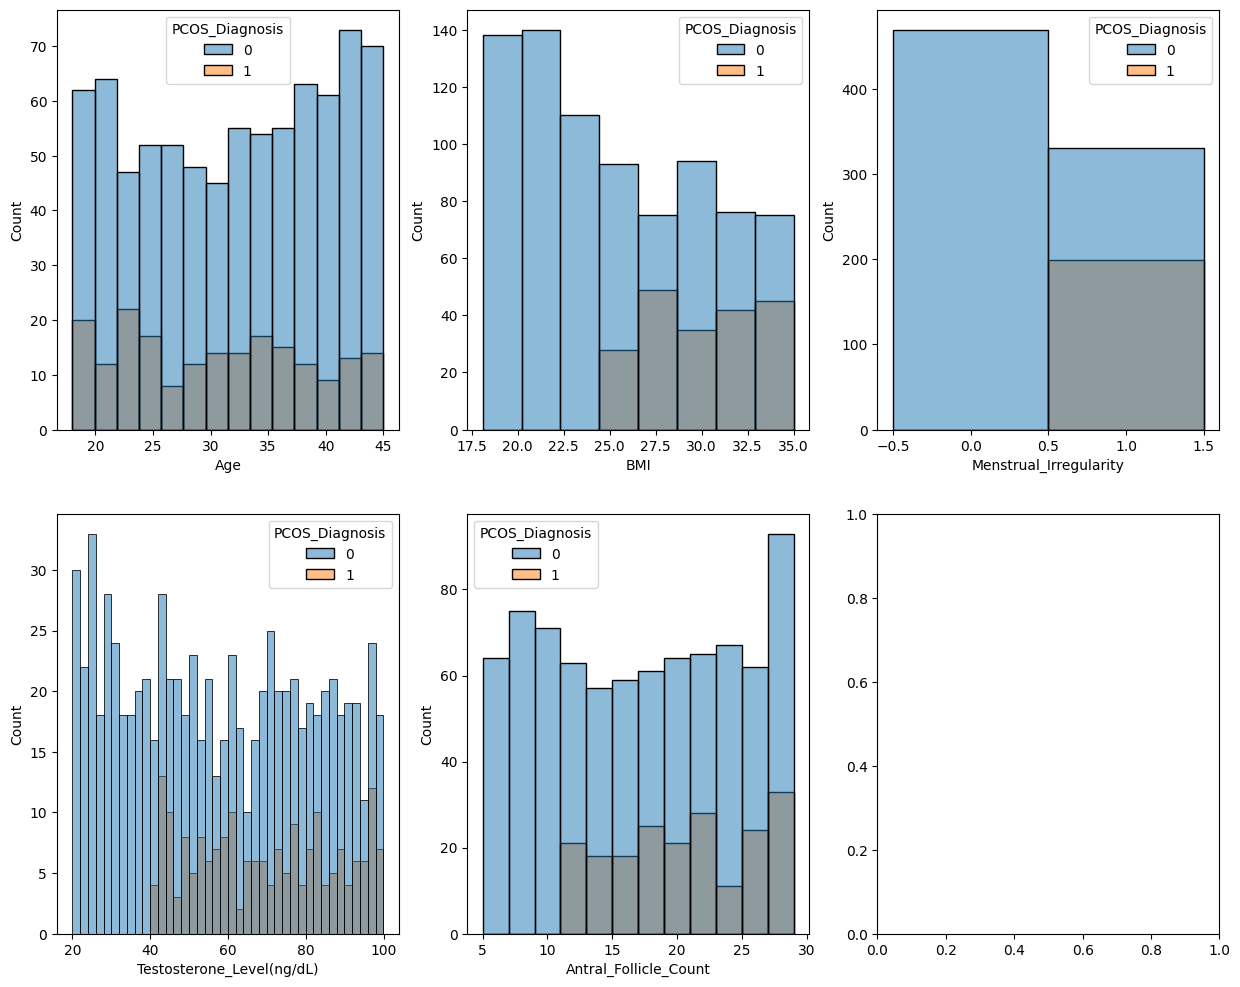

In [111]:

fig, axes = plt.subplots(2,3,figsize=(15,12))
i = 0
j = 0

for feature in features: 
    sns.histplot(pcos, x=feature, binwidth=2, ax=axes[j,i], hue="PCOS_Diagnosis")
    if i == 2:
        i = 0
        j = 1
    else:
        i += 1
    
plt.show()

From the boxplot of PCOS_Diagnosis against Age we see clearly that the diagnosis seems to be distributed across all ages, and there seem to be no significant pattern as for how age might predict PCOS. Comapring with BMI, we see that amongst those with high BMI, there seem to be far more common with PCOS than with those without.  

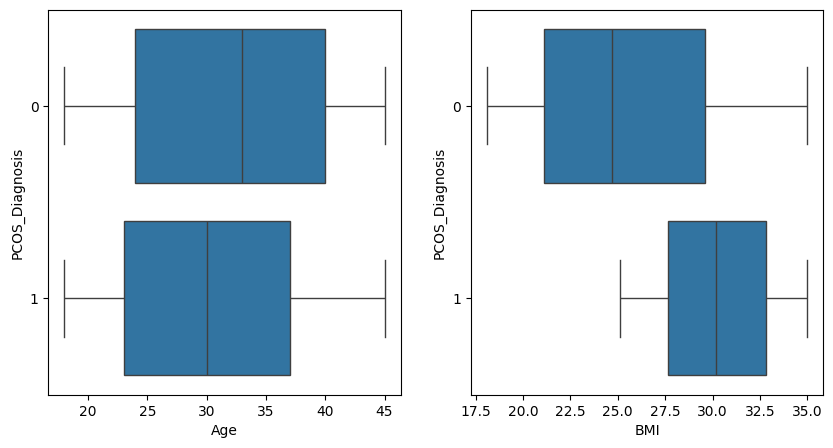

In [112]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
i = 0

for feature in ["Age", "BMI"]: 
    sns.boxplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[i])
    i += 1
    
plt.show()

In [113]:
# fig, axes = plt.subplots(2,3,figsize=(10,10))
# i = 0
# j = 0

# for feature in features: 
#     sns.pointplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[j,i])
#     if i == 2:
#         i = 0
#         j = 1
#     else:
#         i += 1
    
# plt.show()

Further, plotting the scatterplots of the numerical features against PCOS_Diagnosis, we see that apart from Age, the features BMI, testosterone level and follicle count, all seem to be indiactors of PCOS. But we also see that the distribution of those wihtout PCOS in each category is quite evenly distributed. So it seems like these features might be good to predict PCOS, but might not be good to predict who does not have PCOS (the true negatives). 

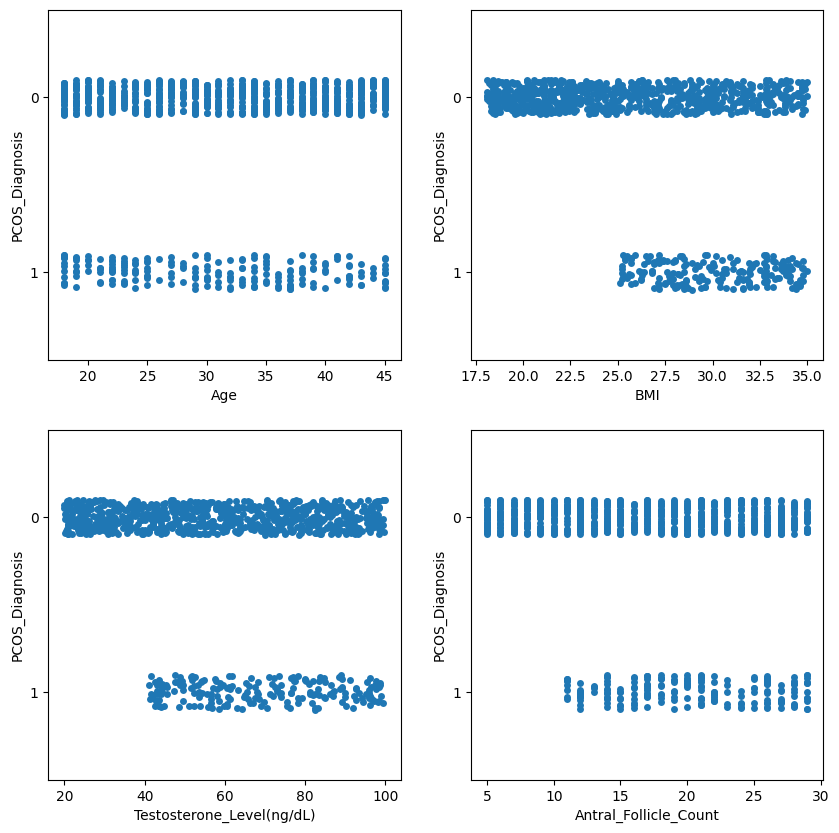

In [114]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
i = 0
j = 0

for feature in numerical_features: 
    sns.stripplot(pcos, x=feature, y="PCOS_Diagnosis", ax=axes[i,j])
    if j == 1:
        i = 1
        j = 0
    else:
        j += 1
    
plt.show()

## Preprocessing for modelling

This is a classification problem because the target variable, PCOS_Diagnosis, is categorical. Since the target variable can only assume two calues (0 or 1), this is a *binary* classification problem. 

The Logistic Regression model is optimized for binary classification, and we will choose this for our baseline model. 
For the comparison model, we will choose a tree model: DecicionTree.

Before we fit the machine learning models, we need to do some preprocessing steps on our data: 
- handle class imbalance
- scale the data as the units are not the same across the features
- split data into test and train data

In [115]:
#This cell can be removed in final report, just for readability while coding
pcos.head()

,Age,BMI,Menstrual_Irregularity,Testosterone_Level(ng/dL),Antral_Follicle_Count,PCOS_Diagnosis
0,24,34.7,1,25.2,20,0
1,37,26.4,0,57.1,25,0
2,32,23.6,0,92.7,28,0
3,28,28.8,0,63.1,26,0
4,25,22.1,1,59.8,8,0


In [116]:
y = pcos["PCOS_Diagnosis"]
X = pcos.drop("PCOS_Diagnosis", axis=1)

# scale the features:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) 

#split dataset into train and test data set:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    stratify=y)

## Baseline model: Logistic Regression


In [117]:
logreg = LogisticRegression() #initialize the model
logreg.fit(X_train, y_train) #fit with training data
y_pred_logreg = logreg.predict(X_test) #predict new data 

logreg_coefs = logreg.coef_[0]

# print(classification_report(y_test, y_pred_logreg))

model_metrics = {
    "LogisticRegression": {
        "accuracy": logreg.score(X_test, y_test), #(TP+TN)/(all predictions)
        "precision": precision_score(y_test, y_pred_logreg), #TP/(TP + FP)
        "recall": recall_score(y_test, y_pred_logreg), # TP/(TP+FN)
        "f1": f1_score(y_test, y_pred_logreg) #harmonic mean of precision and recall
    }
}

logreg_confusion = confusion_matrix(y_test, y_pred_logreg)

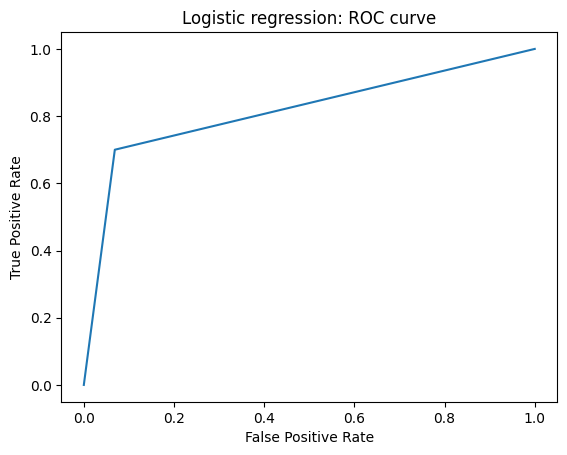

In [118]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg)
plt.plot(fpr, tpr)
plt.title("Logistic regression: ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


## Comparison model: Decision Tree:

In [119]:

dt = DecisionTreeClassifier(
    max_depth=2 #randomly set, can use hyper parameter tuning to find a more optimal values
    )

dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

dt_confusion = confusion_matrix(y_test, y_pred_logreg)
dt_accuracy = (dt_confusion[0][0] + dt_confusion[1][1])/(dt_confusion[0][0]+dt_confusion[0][1]+ dt_confusion[1][0]+ dt_confusion[1][1])

model_metrics["DecisionTree"] = {
        "accuracy": float(dt_accuracy),
        "precision": precision_score(y_test, y_pred_dt),
        "recall": recall_score(y_test, y_pred_dt),
        "f1": f1_score(y_test, y_pred_dt)
}

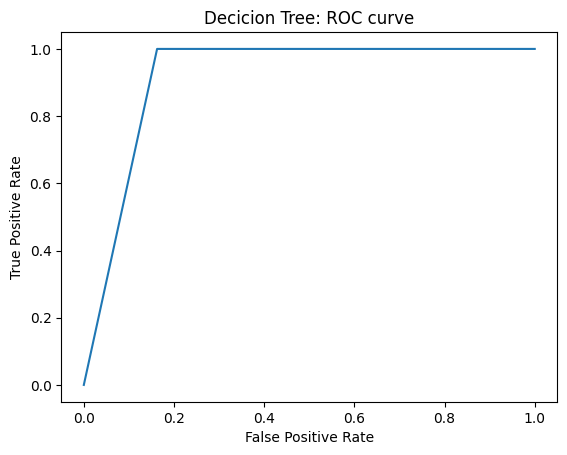

In [120]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_dt)
plt.plot(fpr, tpr)
plt.title("Decicion Tree: ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

## Comparing and evaluating the models

Below is an overview of the metrics for both models. We see that the DecisionTree overall performs better, than logistic regression. 

In [121]:
print("Accuracy:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['accuracy']))
print('\n')

print("Precision:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['precision']))
print('\n')

print("Recall:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['recall']))
print('\n')

print("F1 score:")
for model in model_metrics.keys():
    print(model + ': ' + str(model_metrics[model]['f1']))

Accuracy:
LogisticRegression: 0.885
DecisionTree: 0.885


Precision:
LogisticRegression: 0.717948717948718
DecisionTree: 0.6060606060606061


Recall:
LogisticRegression: 0.7
DecisionTree: 1.0


F1 score:
LogisticRegression: 0.7088607594936709
DecisionTree: 0.7547169811320755


We see that both models are pretty accurate. However, we saw initially that the data set had a class imbalance, and thus accuracy might not be the best metric to evaluate the model performance. 

Logistic Regression have better precision that the Decision Tree. This means that the model was better in prediciting who has PCOS (positive true). 

However, the Decistion Tree have a much higher (in fact a perfect) recall score, which means that this model was better in detecting positive samples than Logistic Regression. This does not however, say anything about how good or bad the Decision Tree model was in predicting the negative values (those without PCOS). In fact, the precision score indicates that the Decsision Tree was actually not better than Logistic Regression when it comes to predicting the true negatives - those without PCOS. 

The F1 score provides a way to evaluate the models taking both precision and recall into account. We see that the Decision Tree has performed much better on this metric indicating that even if the model was not better predicting the negative values, the overall result was still better when we used the Decision Tree. 

## Important features in predicting PCOS

Using the decision tree model, we will find the most important features (in this model) in predicting a PCOS.

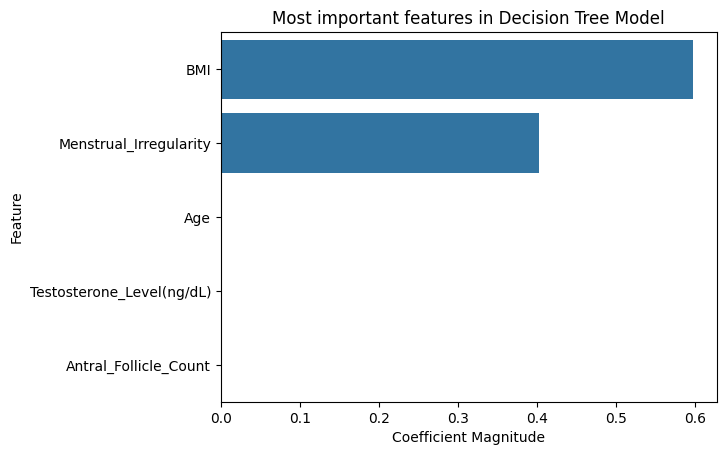

In [122]:
dt_important_features = np.abs(dt.feature_importances_) # one weight for each column (including the "dummy columns")

# Create a DataFrame to pair features with importance
dt_df_feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': dt_important_features})
dt_df_feature_importance = dt_df_feature_importance.sort_values(by="Coefficient", ascending=False).reset_index(drop=True)

# print(dt_df_feature_importance.head())

dt_plot = sns.barplot(
    data=dt_df_feature_importance[:10][:],
    x = "Coefficient",
    y="Feature"
)

plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Most important features in Decision Tree Model")
plt.show()


We see that in this model, `Age ` and `Antral_Follicle_count` was not used in predicting PCOS. `BMI` was by far the most important feature, followed by `Testosterone_Level(ng/dL)` and `Mentrual_Irregularity`. 

## Suggestion for further actions and research

The results in this report gives a clear picture of the most imprtant predictors of PCOS. However, the dataset is limited and one should aim to collect more data both to explore other possible features that might be related to PCOS, or to further strengthen the theory that these three features we found here is in fact as strong as predictors as we have indicated. 

One would also benefit from 
- training the current model on more data
- taking actions to fine tune hyperparameters 
- experimenting with other models, like RandomForest 